In [1]:
# %load sample.py
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import math
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('module://matplotlib_inline.backend_inline')
import matplotlib.ticker as ticker
import numpy as np
from os import system
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

In [2]:
"""========================================================================================
The sample.py includes the following template functions:

1. Encoder, decoder
2. Training function
3. BLEU-4 score function

You have to modify them to complete the lab.
In addition, there are still other functions that you have to 
implement by yourself.

1. Your own dataloader (design in your own way, not necessary Pytorch Dataloader)
2. Output your results (BLEU-4 score, correction words)
3. Plot loss/score
4. Load/save weights
========================================================================================"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#----------Hyper Parameters----------#
embedding_size = 32
hidden_size = 512
#The number of vocabulary
vocab_size = 28
teacher_forcing_ratio = 0.5
LR = 0.05

In [3]:
################################
#Example inputs of compute_bleu
################################
#The target word
reference = 'variable'
#The word generated by your model
output = 'varable'

#compute BLEU-4 score
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

print(compute_bleu(output, reference))

0.5154486831107657


In [4]:
SOS_token = 0
EOS_token = 1
char2index = {"SOS": 0, "EOS": 1}
index2char = {0: "SOS", 1: "EOS"}
a2z = "abcdefghijklmnopqrstuvwxyz"
for index, char in enumerate(a2z, 2):
    char2index[char] = index
    index2char[index] = char

In [5]:
import json
with open("train.json") as f:
    line = json.load(f)

data_list = []
label_list = []
for pair in line:
    label_idx = []
    for character in pair["target"]:
        label_idx.append(char2index[character])
    label_idx.append(char2index["EOS"])
    label_idx = torch.tensor(label_idx)
    for word in pair["input"]:
        word_idx = []
        for character in word:
            word_idx.append(char2index[character])
        word_idx.append(char2index["EOS"])
        word_idx = torch.tensor(word_idx)
        data_list.append(word_idx)
        label_list.append(label_idx)

In [6]:
import json
with open("test.json") as f:
    line = json.load(f)

test_data_list = []
test_label_list = []
for pair in line:
    label_idx = []
    for character in pair["target"]:
        label_idx.append(char2index[character])
    label_idx.append(char2index["EOS"])
    label_idx = torch.tensor(label_idx)
    for word in pair["input"]:
        word_idx = []
        for character in word:
            word_idx.append(char2index[character])
        word_idx.append(char2index["EOS"])
        word_idx = torch.tensor(word_idx)
        test_data_list.append(word_idx)
        test_label_list.append(label_idx)

In [7]:
import json
with open("new_test.json") as f:
    line = json.load(f)

new_test_data_list = []
new_test_label_list = []
for pair in line:
    label_idx = []
    for character in pair["target"]:
        label_idx.append(char2index[character])
    label_idx.append(char2index["EOS"])
    label_idx = torch.tensor(label_idx)
    for word in pair["input"]:
        word_idx = []
        for character in word:
            word_idx.append(char2index[character])
        word_idx.append(char2index["EOS"])
        word_idx = torch.tensor(word_idx)
        new_test_data_list.append(word_idx)
        new_test_label_list.append(label_idx)

In [8]:
def ToOneHot(input_tensor):
    output_tensor = torch.zeros(input_tensor.shape[0], 1, 28)
    for i in range(input_tensor.shape[0]):
        output_tensor[i][0][input_tensor[i]] = 1
    return output_tensor

In [9]:
#Encoder
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size)
        self.rnn = nn.RNN(embedding_size, hidden_size)
#         self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(-1, 1, self.embedding_size)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [10]:
#Decoder
class DecoderRNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.teacher_forcing_ratio = 0.5

        self.embedding = nn.Embedding(output_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size)
        self.rnn = nn.RNN(embedding_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden):
        output = self.embedding(input).view(-1, 1, self.embedding_size)
#         output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.log_softmax(self.out(output))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn):
    encoder.train()
    decoder.train()
    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = len(target_tensor)
    
    target_1hot = ToOneHot(target_tensor).to(device)
    loss = 0
    total_loss = 0

    #----------sequence to sequence part for encoder----------#
    encoder_output, encoder_hidden = encoder(input_tensor.to(device), encoder_hidden)
    decoder_input = torch.tensor([SOS_token], device=device)
    decoder_hidden = encoder_hidden
    decoder_outputs = torch.zeros(target_length, 1, 28).to(device)
    EOS = torch.tensor([EOS_token], device=device)
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
	

    #----------sequence to sequence part for decoder----------#
    
        # Teacher forcing: Feed the target as the next input
    for di in range(target_length):
        if decoder_input == EOS:
            break
        else:
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            decoder_outputs[di][0] = decoder_output
            loss += loss_fn(decoder_output.view(1, -1), target_1hot[di])

            if use_teacher_forcing:
                decoder_input = target_tensor[di].view(1,).to(device)  # Teacher forcing
            else:
                decoder_input = decoder_output.argmax()

#     decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
#     loss = loss_fn(decoder_output.view(1, -1), ToOneHot(torch.tensor([EOS_token]))[0].view(1, -1).to(device))
#     total_loss += loss.item()

#     else:
        # Without teacher forcing: use its own predictions as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
#             topv, topi = decoder_output.topk(1)
#             decoder_input = topi.squeeze().detach()  # detach from history as input

#             loss += criterion(decoder_output, target_tensor[di])
#             if decoder_input.item() == EOS_token:
#                 break



#     loss = loss_fn(decoder_outputs.squeeze(1), target_1hot.squeeze(1))
#     total_loss += loss.item()
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

#     return total_loss
    return loss.item() / target_length

In [12]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
def trainIters(data_list, label_list, encoder, decoder, n_iters,
               print_every=1000, plot_every=100, learning_rate=0.0001, plot_history=[]):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    # your own dataloader
#     training_pairs = ...

    loss_fn = nn.CrossEntropyLoss()

    for i in range(n_iters):
#         training_pair = training_pairs[iter - 1]
        input_tensor = data_list[i]
        target_tensor = label_list[i]
#         print(target_tensor)

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, loss_fn)
        print_loss_total += loss
        plot_loss_total += loss

        if (i+1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
#             print(print_loss_avg)
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, i / (n_iters+1)),
                                         i, i / (n_iters+1) * 100, print_loss_avg), end="\r")
    plot_history.append(plot_loss_total / len(data_list))
    print("\nLoss:", plot_loss_total / len(data_list))
            
	

In [14]:
def Evaluate_bleu(test_data, test_label, encoder, decoder):
    with torch.no_grad():
        total_bleu = 0.
        for i in range(len(test_data)):
            init_hid = encoder.initHidden()
            out, hid = encoder(test_data[i].to(device), init_hid)
            dec_hid = hid
            dec_in = torch.tensor([SOS_token], device=device)
            generated_word = []
            while True:
                dec_out, dec_hid = decoder(dec_in, dec_hid)
                generated_word.append(index2char[dec_out.argmax(dim=2).item()])
                dec_in = dec_out.argmax(dim=2).view(1,)
                if dec_in.item() == EOS_token:
                    break

            target_word = []
            for j in range(len(test_label[i])):
                target_word.append(index2char[test_label[i][j].item()])
                
            total_bleu += compute_bleu(generated_word, target_word)
        return total_bleu / len(test_data)

In [15]:
encoder1 = EncoderRNN(vocab_size, embedding_size, hidden_size).to(device)
decoder1 = DecoderRNN(embedding_size, hidden_size, vocab_size).to(device)

In [16]:
plot_history = []
bleu_history = []

In [17]:
for i in range(50):
    print(f"Epochs: {i}")
    trainIters(data_list, label_list, encoder1, decoder1, len(data_list), plot_history=plot_history)
    bleu_score = Evaluate_bleu(test_data_list, test_label_list, encoder1, decoder1)
    print(f"Bleu score: {bleu_score}")
    bleu_history.append(bleu_score)

Epochs: 0
1m 17s (- 0m 6s) (11999 92%) 1.93490
Loss: 1.8997480002440437
Bleu score: 0.11793764342129111
Epochs: 1
1m 19s (- 0m 6s) (11999 92%) 1.40448
Loss: 1.4808628321279897
Bleu score: 0.2172421899996778
Epochs: 2
1m 20s (- 0m 6s) (11999 92%) 1.09415
Loss: 1.2197327714804789
Bleu score: 0.2952050876902603
Epochs: 3
1m 20s (- 0m 6s) (11999 92%) 0.91235
Loss: 1.0731065150832484
Bleu score: 0.41156354571503223
Epochs: 4
1m 20s (- 0m 6s) (11999 92%) 0.75704
Loss: 0.9605037884187603
Bleu score: 0.4706009144508546
Epochs: 5
1m 20s (- 0m 6s) (11999 92%) 0.65793
Loss: 0.8612166672532952
Bleu score: 0.49993660401800905
Epochs: 6
1m 21s (- 0m 6s) (11999 92%) 0.54243
Loss: 0.7629552379775758
Bleu score: 0.5072888534262027
Epochs: 7
1m 21s (- 0m 6s) (11999 92%) 0.48764
Loss: 0.6776485935095663
Bleu score: 0.5761383252440081
Epochs: 8
1m 21s (- 0m 6s) (11999 92%) 0.41867
Loss: 0.5919852122763174
Bleu score: 0.5941083247910874
Epochs: 9
1m 22s (- 0m 6s) (11999 92%) 0.36162
Loss: 0.512857027060767

In [18]:
word_idx = 15
using_data = test_data_list
using_label = test_label_list
with torch.no_grad():
    init_hid = encoder1.initHidden()
    out, hid = encoder1(using_data[word_idx].to(device), init_hid)
    dec_hid = hid
    dec_in = torch.tensor([SOS_token], device=device)
    generated_word = []
#     for i in range(len(using_label[word_idx])):
    while True:
        dec_out, dec_hid = decoder1(dec_in, dec_hid)
        generated_word.append(index2char[dec_out.argmax(dim=2).item()])
        dec_in = dec_out.argmax(dim=2).view(1,)
        if dec_in.item() == EOS_token:
            break
    print(generated_word)

['b', 'a', 's', 'i', 'c', 'a', 'l', 'l', 'y', 'EOS']


In [19]:
target_word = []
for i in range(len(using_label[word_idx])):
    target_word.append(index2char[using_label[word_idx][i].item()])
print(target_word)

['b', 'a', 's', 'i', 'c', 'a', 'l', 'l', 'y', 'EOS']


In [20]:
compute_bleu(generated_word, target_word)

1.0

In [21]:
print(plot_history)

[1.8997480002440437, 1.4808628321279897, 1.2197327714804789, 1.0731065150832484, 0.9605037884187603, 0.8612166672532952, 0.7629552379775758, 0.6776485935095663, 0.5919852122763174, 0.5128570270607676, 0.43825856736462915, 0.3722848526978707, 0.31791236487818386, 0.26472071403169894, 0.23101412052027304, 0.19990446245729654, 0.183835646844835, 0.16979179186463442, 0.15750820672788646, 0.1489637730679362, 0.14245574518737558, 0.14120459320521503, 0.1307490734383274, 0.13576641908582937, 0.13149855955754713, 0.13000569642026685, 0.13225552092159318, 0.13191062212033258, 0.13264167359927667, 0.1322267336165738, 0.12869256549576324, 0.12646660680553132, 0.1252596753224808, 0.12889530202022526, 0.1268678189467833, 0.12058360976444227, 0.12397519272448339, 0.11861549692229467, 0.1226792608400869, 0.12221433610289877, 0.11946651678159327, 0.12012532987762135, 0.11701019675880418, 0.11642005252758317, 0.11504086548803198, 0.11744593622408377, 0.1137406618945874, 0.1153939010462382, 0.1168554189

In [22]:
print(bleu_history)

[0.11793764342129111, 0.2172421899996778, 0.2952050876902603, 0.41156354571503223, 0.4706009144508546, 0.49993660401800905, 0.5072888534262027, 0.5761383252440081, 0.5941083247910874, 0.632414997768545, 0.6687130158436841, 0.6431272200628401, 0.6666373502789199, 0.7429426757248053, 0.690609255071219, 0.7124806050637084, 0.7445081277032098, 0.7527140154186572, 0.755632119720695, 0.785528888146369, 0.8198926386997987, 0.7978208768659961, 0.8150022413711011, 0.8055424900229804, 0.7842346254632285, 0.8272106825976182, 0.8049028171110233, 0.7652051747365158, 0.8546848348880203, 0.8264421935799566, 0.8588420156072207, 0.8588514208464977, 0.8147794915852399, 0.8355245430467366, 0.8654341854954404, 0.8631417051629281, 0.8876007868846567, 0.8908631211136914, 0.8848084698682572, 0.9033556283057587, 0.9190714624642757, 0.9264127416278177, 0.8833046739771957, 0.9137426785478666, 0.9264088449826816, 0.9042884202114624, 0.9498328293379495, 0.9186533985388836, 0.9192581026573127, 0.9010627622226609]


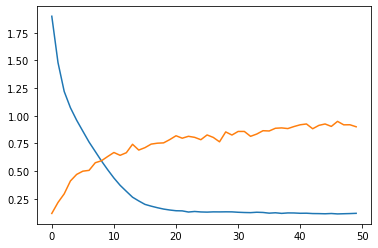

In [24]:
x = np.arange(50)
plt.plot(x, plot_history)
plt.plot(x, bleu_history)